# MTGBM

In [1]:
import os
import json
import torch
import random
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from hyperopt import fmin, tpe, hp, Trials
from scipy.stats import pearsonr
import numpy as np
from copy import deepcopy
import lightgbmmt as lgb
import matplotlib.pyplot as plt
import math
current_dir = os.getcwd()


def return_mtgbm_x_y(df_data, tasks):
    y = np.array(df_data[tasks].values)

    auxiliary_data = []
    if use_t_ph_embedding:
        ph = df_data['ph'].values.reshape(-1, 1)
        t = df_data['t'].values.reshape(-1, 1)
        auxiliary_data.append(ph)
        auxiliary_data.append(t)

    if use_mw_logp:
        mw = df_data['mw'].values.reshape(-1, 1)
        logp = df_data['logp'].values.reshape(-1, 1)
        auxiliary_data.append(mw)
        auxiliary_data.append(logp)

    protein_data = np.array(df_data[protein_column].tolist())
    substrate_data = np.array(df_data[substrate_column].tolist())

    x = np.hstack([protein_data, substrate_data] + auxiliary_data)
    return x, y

def return_scores(y_true, y_pred):
    mask = y_true != fill_nan_value
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    pcc = pearsonr(y_true, y_pred)[0]

    return rmse, mae, r2, pcc

def print_scores(task_scores_dict):
    for task_name in task_names:
        print(f"{task_name}\t RMSE\t MAE\t R2\t PCC\t")

        task_val_scores = task_scores_dict[task_name]['val']
        task_test_scores = task_scores_dict[task_name]['test']

        val_metrics = [f"{np.mean(task_val_scores[metric_name]):.4f}\t" for metric_name in
                       score_names]
        print("Val  " + " ".join(val_metrics))

        test_metrics = [f"{np.mean(task_test_scores[metric_name]):.4f}\t" for metric_name in
                        score_names]
        print("Test " + " ".join(test_metrics))

def pcgrad(gradients):
    adjusted_gradients = gradients.clone()

    for i in range(num_tasks):
        g_i = adjusted_gradients[:, i]
        for j in range(num_tasks):
            if i != j:  # 跳过与自身的比较
                g_j = adjusted_gradients[:, j]

                # 计算点积并检测冲突
                dot_product = torch.dot(g_i, g_j)
                if dot_product < 0:  # 仅在点积为负时调整
                    projection = (dot_product / (torch.norm(g_j) ** 2 + 1e-8)) * g_j
                    g_i -= projection  # 对 g_i 进行投影调整

        # 更新调整后的梯度
        adjusted_gradients[:, i] = g_i

    # final_gradient = adjusted_gradients.mean(dim=1)  # 对任务维度求平均
    return adjusted_gradients

def self_kcatkm_rmse(preds, train_data):
    labels = torch.tensor(train_data.get_label(), device=device)
    preds = torch.tensor(preds, device=device)

    # extract kcatkm values
    labels = labels.view(num_tasks, -1).T[:, num_tasks - 1]
    preds = preds.view(num_tasks, -1).T[:, num_tasks - 1]

    # mask
    valid_mask = labels != fill_nan_value
    valid_labels = labels[valid_mask]
    valid_preds = preds[valid_mask]

    kcatkm_rmse = torch.sqrt(torch.mean((valid_labels - valid_preds) ** 2))

    return 'rmse_kcatkm', kcatkm_rmse.item(), False


# TODO Train model
def train_mtgbm(params):
    def cal_grad(preds, train_data, ep=0):
        labels = torch.tensor(train_data.get_label(), device=device)
        preds = torch.tensor(preds, device=device)
        labels = labels.view(num_tasks, -1).T
        preds = preds.view(num_tasks, -1).T

        # mask
        valid_mask = labels != fill_nan_value
        grad = torch.zeros_like(preds)
        grad[valid_mask] = preds[valid_mask] - labels[valid_mask]

        # project
        grad = pcgrad(grad)

        # Calculate cosine similarity between gradients at the current epoch
        grad_similarity = []
        for i in range(num_tasks):
            for j in range(i + 1, num_tasks):
                task1_grad = grad[:, i].unsqueeze(1)
                task2_grad = grad[:, j].unsqueeze(1)
                similarity = torch.cosine_similarity(task1_grad, task2_grad, dim=0).item()
                grad_similarity.append(similarity)

        avg_similarity = np.mean(grad_similarity)  # 计算均值
        if record:
            gradient_similarities[fold_idx-1].append(avg_similarity)

        # sum
        grad_final = grad.mean(dim=1)

        # Hessian
        grad_flattened = grad.T.flatten()
        hess = torch.ones_like(grad_final)
        hess2 = torch.ones_like(grad_flattened)

        return grad_final.cpu().numpy(), hess.cpu().numpy(), grad_flattened.cpu().numpy(), hess2.cpu().numpy()

    temp_params = deepcopy(params)
    temp_params.update({"verbosity": -1, "objective": "custom", "num_labels": num_tasks, "tree_learner": 'serial2', "num_threads": num_threads})
    num_iterations = temp_params.pop("num_iterations")

    task_scores_dict = {task_name: {'val': {name: [] for name in score_names}, 'test': {name: [] for name in score_names}} for task_name in task_names}

    for fold_idx, (train_index, val_index) in enumerate(kf.split(train_val_x), start=1):
        print(f"Fold {fold_idx}")
        # split dataset
        train_x, val_x = train_val_x[train_index], train_val_x[val_index]
        train_y, val_y = train_val_y[train_index], train_val_y[val_index]

        train_data = lgb.Dataset(train_x, label=train_y)

        val_data = lgb.Dataset(val_x, label=val_y)

        # get the best epoch number
        record = True
        evals_result_mt = {}
        lgb.train(temp_params, train_data, num_iterations, valid_sets=[val_data],
                  fobj=cal_grad, feval=self_kcatkm_rmse, verbose_eval=1000, evals_result=evals_result_mt,
                  callbacks=[lgb.early_stopping(stopping_rounds=500)])
        valid_records = evals_result_mt['valid_0']['rmse_kcatkm']
        min_index = np.argmin(np.array(valid_records))
        print(f"valid_records min_index {min_index}")

        # train model for all scores of validation and test
        record = False
        train_data = lgb.Dataset(train_x, label=train_y)
        val_data = lgb.Dataset(val_x, label=val_y)
        evals_result_mt = {}
        model = lgb.train(temp_params, train_data, min_index + 1, valid_sets=[val_data],
                          fobj=cal_grad, feval=self_kcatkm_rmse, verbose_eval=1000,
                          evals_result=evals_result_mt)
        model.set_num_labels(num_tasks)

        # validation predict
        val_predicted = model.predict(val_x)
        val_scores = {task_name: return_scores(val_y[:, idx], val_predicted[:, idx]) for idx, task_name in
                      enumerate(task_names)}

        # test predict
        test_predicted = model.predict(test_x)
        test_scores = {task_name: return_scores(test_y[:, idx], test_predicted[:, idx]) for idx, task_name in
                       enumerate(task_names)}

        # record
        for task_name in task_names:
            for score_idx, score_name in enumerate(score_names):
                task_scores_dict[task_name]['val'][score_name].append(val_scores[task_name][score_idx])
                task_scores_dict[task_name]['test'][score_name].append(test_scores[task_name][score_idx])
        print(f"Val  {val_scores} \n Test {test_scores}\n")

    print_scores(task_scores_dict)


# init seed
random_state = 66
random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state)

# config
protein_column,  substrate_column = 'prott5', 'molebert'
input_model = 'mtgbm_km_kcat_kcatkm'
dataset_path = f'{current_dir}/../data_process/dataset/df_all_log_transformed.pkl'
params_json_path = f'{current_dir}/{input_model}_params.json'
use_t_ph_embedding = True
use_mw_logp = True
num_threads = 32
search_max_evals = 60
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Current device is {device}")

# input
score_names = ['rmse', 'mae', 'r2', 'pcc']
task_names = ['logkm', 'logkcat', 'logkcatkm']
num_tasks = len(task_names)
df_input = pd.read_pickle(dataset_path)
fill_nan_value = -100
df_input = df_input.fillna(fill_nan_value)

# split dataset
df_train_val, df_test = train_test_split(df_input, test_size=0.2, random_state=random_state)
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
train_val_x, train_val_y = return_mtgbm_x_y(df_train_val, task_names)
test_x, test_y = return_mtgbm_x_y(df_test, task_names)

if os.path.exists(params_json_path):
    with open(params_json_path, 'r') as json_file:
        best_params = json.load(json_file)

print('best_params:', best_params)
print('using km kcat kcatkm resample')
record = True
gradient_similarities = [[] for _ in range(5)]
train_mtgbm(best_params)
np.save(f'{current_dir}/PCGrad_gradient_similarities_log.npy',np.array(gradient_similarities))

Current device is cuda:0
best_params: {'bagging_fraction': 0.729611058732434, 'feature_fraction': 0.6643005188332146, 'lambda_l1': 0.346846951564011, 'lambda_l2': 0.7149783548509333, 'learning_rate': 0.07838547411322133, 'max_bin': 95, 'max_depth': 9, 'min_data_in_leaf': 21, 'num_iterations': 3273, 'num_leaves': 2350}
using km kcat kcatkm resample
Fold 1
Training until validation scores don't improve for 500 rounds
[1000]	valid_0's rmse_kcatkm: 2.77608
[2000]	valid_0's rmse_kcatkm: 2.72049
[3000]	valid_0's rmse_kcatkm: 2.7113
Did not meet early stopping. Best iteration is:
[3067]	valid_0's rmse_kcatkm: 2.71085
valid_records min_index 3066
[1000]	valid_0's rmse_kcatkm: 2.77608
[2000]	valid_0's rmse_kcatkm: 2.72049
[3000]	valid_0's rmse_kcatkm: 2.7113
inner_predict 22338
inner_predict 27921
Val  {'logkm': (1.960829596974407, 1.333386586353164, 0.5623167167157751, 0.7647984103844179), 'logkcat': (2.120953741138861, 1.4409126728824737, 0.630103365200489, 0.7943291451174239), 'logkcatkm': (

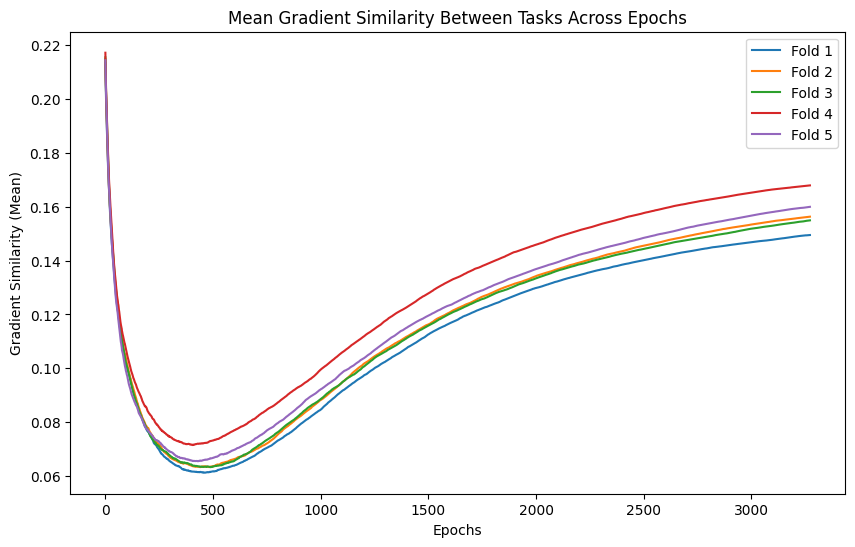

In [2]:
# 绘制并保存相似度变化图
def plot_gradient_similarity(gradient_similarities):
    # epochs = np.arange(1, len(gradient_similarities) + 1)
    plt.figure(figsize=(10, 6))

    for fold_idx in range(5):  # 假设是5折交叉验证，根据需要调整
        similarity_values = np.array(gradient_similarities[fold_idx])
        plt.plot([_ for _ in range(len(similarity_values))], similarity_values, label=f"Fold {fold_idx + 1}")

    plt.xlabel('Epochs')
    plt.ylabel('Gradient Similarity (Mean)')
    plt.title('Mean Gradient Similarity Between Tasks Across Epochs')
    plt.legend()
    plt.grid(False)

    # output_dir = '/mnt/data/gradient_similarity_plot.png'
    # plt.savefig(output_dir)
    plt.show()
plot_gradient_similarity(gradient_similarities)